<a href="https://colab.research.google.com/github/lahirunie-dulsara/EN3150-Assignment-3-CNN/blob/Lahirunie/RealWaste.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive
Mounted at /content/drive


In [2]:
import zipfile, os, re, shutil
from PIL import Image

zip_path = "/content/drive/MyDrive/CNN_Assignment3/realwaste.zip"

extract_path = "/content/extracted_zip"
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Unzipped to:", extract_path)


Unzipped to: /content/extracted_zip


In [3]:
base_dir = "/content/extracted_zip/realwaste-main/RealWaste"
for folder in os.listdir(base_dir):
    count = len(os.listdir(os.path.join(base_dir, folder)))
    print(f"{folder}: {count} images")

Textile Trash: 318 images
Miscellaneous Trash: 495 images
Vegetation: 436 images
Food Organics: 411 images
Cardboard: 461 images
Metal: 790 images
Paper: 500 images
Glass: 420 images
Plastic: 921 images


In [4]:
pip install split-folders

In [5]:
import splitfolders  # install with: pip install split-folders

input_folder = "/content/extracted_zip/realwaste-main/RealWaste"
output_folder = "/content/extracted_zip/realwaste-main/realwaste_split"

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.7, .15, .15))

Copying files: 4752 files [00:03, 1252.39 files/s]


In [6]:
base_dir = "/content/extracted_zip/realwaste-main/realwaste_split"

# Count images in each subfolder
for split in ['train', 'val', 'test']:
    split_path = os.path.join(base_dir, split)
    print(f"\n📁 {split.upper()} SET")
    total = 0
    for cls in os.listdir(split_path):
        cls_path = os.path.join(split_path, cls)
        count = len(os.listdir(cls_path))

        total += count
        print(f"  {cls}: {count} images")
    print(f"  ➜ Total {split}: {total} images")


📁 TRAIN SET
  Textile Trash: 222 images
  Miscellaneous Trash: 346 images
  Vegetation: 305 images
  Food Organics: 287 images
  Cardboard: 322 images
  Metal: 553 images
  Paper: 350 images
  Glass: 294 images
  Plastic: 644 images
  ➜ Total train: 3323 images

📁 VAL SET
  Textile Trash: 47 images
  Miscellaneous Trash: 74 images
  Vegetation: 65 images
  Food Organics: 61 images
  Cardboard: 69 images
  Metal: 118 images
  Paper: 75 images
  Glass: 63 images
  Plastic: 138 images
  ➜ Total val: 710 images

📁 TEST SET
  Textile Trash: 49 images
  Miscellaneous Trash: 75 images
  Vegetation: 66 images
  Food Organics: 63 images
  Cardboard: 70 images
  Metal: 119 images
  Paper: 75 images
  Glass: 63 images
  Plastic: 139 images
  ➜ Total test: 719 images


In [50]:
import os
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms

# Data augmentation step

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=15, translate=(0.1,0.1), scale=(0.9,1.1)),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.ToTensor()
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder("/content/extracted_zip/realwaste-main/realwaste_split/train", transform=train_transforms)
val_dataset   = datasets.ImageFolder("/content/extracted_zip/realwaste-main/realwaste_split/val", transform=val_test_transforms)
test_dataset  = datasets.ImageFolder("/content/extracted_zip/realwaste-main/realwaste_split/test", transform=val_test_transforms)


In [15]:
import numpy as np

class_counts = np.bincount(train_dataset.targets)
print("Class counts:", class_counts)

# Handling the class imbalance

# Compute class weights (inverse of frequency)
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)

sample_weights = [class_weights[label] for label in train_dataset.targets]

print("📊 Class counts per category:")
for cls, count in zip(train_dataset.classes, class_counts):
    print(f"  {cls:15s}: {count}")

print("\n⚖️ Class weights (inverse of frequency):")
for cls, w in zip(train_dataset.classes, class_weights):
    print(f"  {cls:15s}: {w:.6f}")

Class counts: [322 287 294 553 346 350 644 222 305]
📊 Class counts per category:
  Cardboard      : 322
  Food Organics  : 287
  Glass          : 294
  Metal          : 553
  Miscellaneous Trash: 346
  Paper          : 350
  Plastic        : 644
  Textile Trash  : 222
  Vegetation     : 305

⚖️ Class weights (inverse of frequency):
  Cardboard      : 0.003106
  Food Organics  : 0.003484
  Glass          : 0.003401
  Metal          : 0.001808
  Miscellaneous Trash: 0.002890
  Paper          : 0.002857
  Plastic        : 0.001553
  Textile Trash  : 0.004505
  Vegetation     : 0.003279


In [51]:
from torch.utils.data import WeightedRandomSampler, DataLoader

sampler = WeightedRandomSampler(
    weights=sample_weights,      # weight per sample
    num_samples=len(sample_weights),  # total samples to draw per epoch
    replacement=True             # allow repeated samples
)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"\n✅ WeightedRandomSampler created successfully!")
print(f"➡️ Total samples in epoch: {len(sample_weights)}")
print(f"➡️ Batch size: {train_loader.batch_size}")
print(f"➡️ Total batches per epoch: {len(train_loader)}")


✅ WeightedRandomSampler created successfully!
➡️ Total samples in epoch: 3323
➡️ Batch size: 32
➡️ Total batches per epoch: 104


In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class WasteCNN(nn.Module):
    def __init__(self, num_classes=9):
        super().__init__()
        # 2 Convolutional layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)   # 64 filters, 3x3 kernel
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # 128 filters, 3x3 kernel
        self.pool = nn.MaxPool2d(2,2)

        # Fully connected layer
        # After 2 poolings: 224x224 → 56x56
        self.fc1 = nn.Linear(128*56*56, 256)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 64x112x112
        x = self.pool(F.relu(self.conv2(x)))  # 128x56x56
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = WasteCNN(num_classes=9).to(device)
print(model)


WasteCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=401408, out_features=256, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=256, out_features=9, bias=True)
)


In [53]:
import torch
print("✅ CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))


✅ CUDA available: True
GPU name: Tesla T4


In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = WasteCNN(num_classes=9).to(device)



In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5
)

num_epochs = 60
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] — Train Loss: {epoch_loss:.4f}")



Epoch [1/60] — Train Loss: 2.9130
Epoch [10/60] — Train Loss: 1.9115


In [48]:
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [49]:
val_correct = 0
val_total = 0

model.eval()  # disable dropout/batchnorm randomness

with torch.no_grad():  # no gradient computation
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()

val_acc = 100 * val_correct / val_total
val_accuracies.append(val_acc)

 # Step scheduler
    scheduler.step(epoch_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] — Train Loss: {epoch_loss:.4f} — Val Acc: {val_acc:.2f}%")



✅ Validation Accuracy: 59.86%


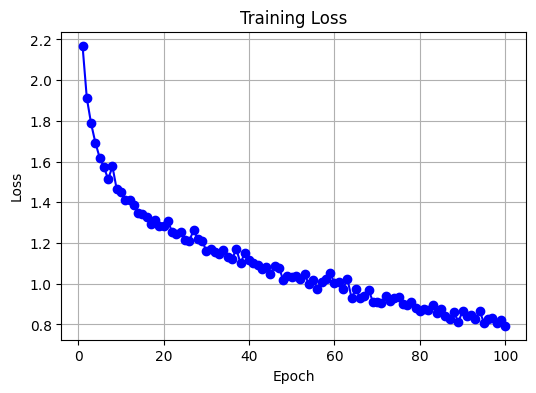

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(range(1, num_epochs+1), train_losses, marker='o', color='blue')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()
